In [58]:
#Importing libraries

import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from PIL import Image
import geopandas as gpd
import geodatasets
from shapely.geometry import Point

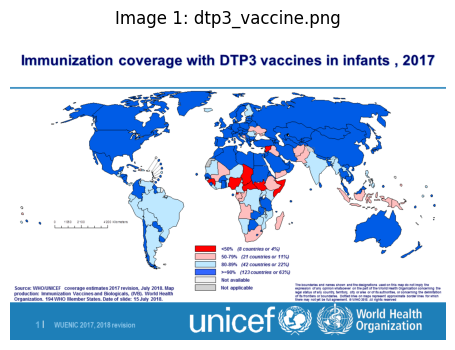

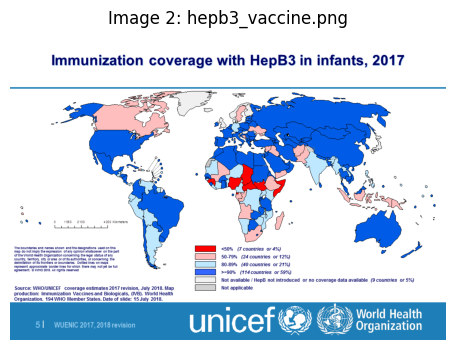

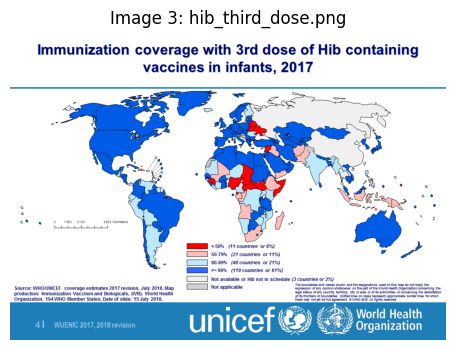

In [59]:
# Displaying the first 3 images

# Path to raw images
raw_image_path = '../data/raw_maps/'

# Listing all image files
image_files = [f for f in os.listdir(raw_image_path) if f.endswith(('.png'))]

# Displaying the first 3 images
for i, file_name in enumerate(image_files[:3]):
    img_path = os.path.join(raw_image_path, file_name)
    img = Image.open(img_path)

    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.title(f'Image {i+1}: {file_name}')
    plt.axis('off')
    plt.show()


In [ ]:
# Loading image
img_path = "../data/raw_maps/dtp3_vaccine.png"
image = cv2.imread(img_path)

# Example: High demand mask
lower = np.array([0,0,200], dtype="uint8")
upper = np.array([50,50,255], dtype="uint8")
mask = cv2.inRange(image, lower, upper)

# Finding contours of country-like shapes
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

country_segments = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 500:  # filter small regions
        x, y, w, h = cv2.boundingRect(cnt)
        roi = image[y:y+h, x:x+w]
        country_segments.append(roi)

print(f"Extracted {len(country_segments)} high-demand country segments.")


Extracted 2 high-demand country segments.


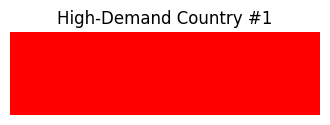

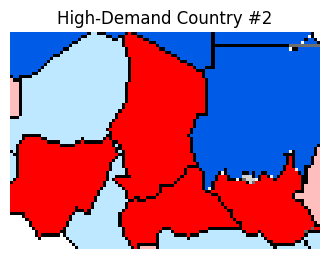

In [106]:
# Displaying extracted country segments
for i, roi in enumerate(country_segments):
    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.title(f"High-Demand Country #{i+1}")
    plt.axis("off")
    plt.show()

In [107]:
# Loading admin-0 countries
shapefile_path = "../data/shapefiles/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)

print(world.columns.tolist())
print(world.head())

['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT', 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG', 'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT', 'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13', 'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10', 'ISO_A2', 'ISO_A2_EH', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'ISO_N3_EH', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 'ADM0_ISO', 'ADM0_DIFF', 'ADM0_TLC', 'ADM0_A3_US', 'ADM0_A3_FR', 'ADM0_A3_RU', 'ADM0_A3_ES', 'ADM0_A3_CN', 'ADM0_A3_TW', 'ADM0_A3_IN', 'ADM0_A3_NP', 'ADM0_A3_PK', 'ADM0_A3_DE', 'ADM0_A3_GB', 'ADM0_A3_BR', 'ADM0_A3_IL', 'ADM0_A3_PS', 'ADM0_A3_SA', 'ADM0_A3_EG', 'ADM0_A3_MA', 'ADM0_A3_PT', 'ADM0_A3_AR', 'ADM0_A3_JP', 'ADM0_A3_KO', 'ADM0_A3_VN', 'ADM0_A3_TR', 'AD

In [115]:
# Create directories
for demand in ["High", "Medium", "Low"]:
    os.makedirs(f"data/train/{demand}", exist_ok=True)

# Load map image
img = cv2.imread("data/raw_maps/measles_first_dose.png")

# Load admin-0 countries
world = gpd.read_file("../data/shapefiles/ne_110m_admin_0_countries.shp")

# Define colors for each demand level
colors = {"High": "red", "Medium": "green", "Low": "blue"}

# Sample results
results = [("United Republic of Tanzania", "High"),
    ("Fiji", "Medium"),
    ("Canada", "Low")]

# Iterate through the results and save images
for country, demand in results:
    country_clean = country.strip().lower()
    match = world[world["ADMIN"] == country_clean]

    if not match.empty:
        # Get centroid for labeling
        centroid = match.geometry.centroid.iloc[0]
        x, y = centroid.x, centroid.y

        # Create a mask for the country
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [match.geometry.values[0].exterior], 255)

        # Apply the mask to the image
        masked_img = cv2.bitwise_and(img, img, mask=mask)

        # Save the image
        output_path = f"data/train/{demand}/{country_clean}.png"
        cv2.imwrite(output_path, masked_img)

        print(f"Saved image for {country} with {demand} demand.")
    else:
        print(f"[!] Country '{country}' not found.")

[!] Country 'United Republic of Tanzania' not found.
[!] Country 'Fiji' not found.
[!] Country 'Canada' not found.


C:\Users\Nicolle School\AppData\Local\Temp\ipykernel_24192\1638586309.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = match.geometry.centroid.iloc[0]
C:\Users\Nicolle School\AppData\Local\Temp\ipykernel_24192\1638586309.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = match.geometry.centroid.iloc[0]
C:\Users\Nicolle School\AppData\Local\Temp\ipykernel_24192\1638586309.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = match.geometry.centroid.iloc[0]


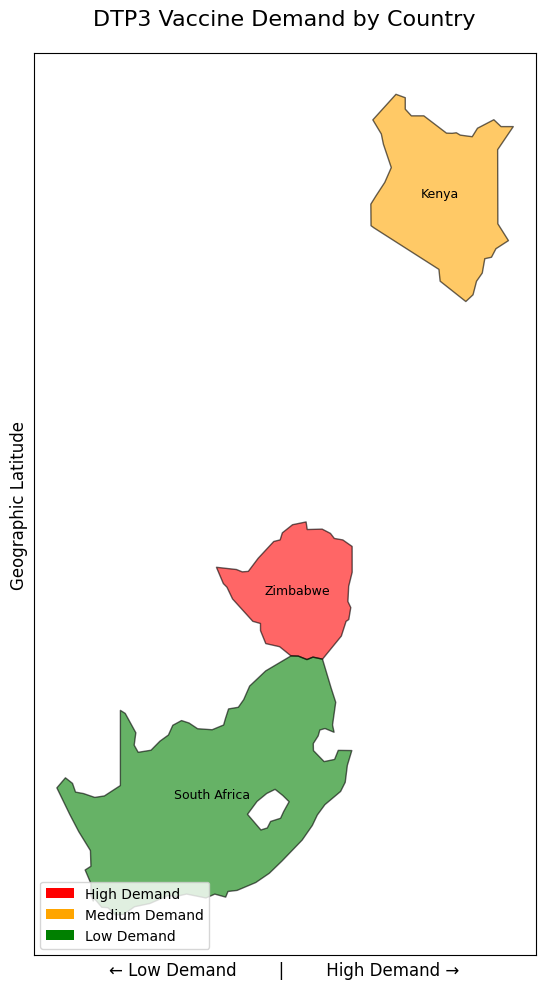

In [ ]:
# Loading shapefile
world = gpd.read_file("../data/shapefiles/ne_110m_admin_0_countries.shp")  # Update path
world["ADMIN"] = world["ADMIN"].str.strip().str.lower()

# Sample results


# Plot setup
fig, ax = plt.subplots(figsize=(14, 10))

for country, demand in results:
    country_clean = country.strip().lower()
    match = world[world["ADMIN"] == country_clean]

    if not match.empty:
        # Plot the country polygon
        match.plot(ax=ax, color=colors[demand], edgecolor="black", alpha=0.6)

        # Get centroid for labeling
        centroid = match.geometry.centroid.iloc[0]
        ax.text(centroid.x, centroid.y, country.title(), fontsize=9, ha="center", va="center")

    else:
        print(f"[!] Country '{country}' not found.")

# Customize axis
ax.set_title("DTP3 Vaccine Demand by Country", fontsize=16, pad=20)
ax.set_xlabel("← Low Demand        |        High Demand →", fontsize=12)
ax.set_ylabel("Geographic Latitude", fontsize=12)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide ticks

# Add a legend manually
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[d], label=d + " Demand") for d in colors]
ax.legend(handles=legend_elements, loc="lower left")

plt.tight_layout()
plt.show()
